<a href="https://colab.research.google.com/github/medha-mannem/pothole-detection/blob/main/pd_final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import MobileNet
from google.colab import drive
import seaborn as sns
import tensorflow as tf

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define the ImageDataGenerator for training and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Path to your training and testing directories
train_dir = '/content/drive/MyDrive/pimages/train'
test_dir = '/content/drive/MyDrive/pimages/test'


In [7]:
# Create training and testing sets
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

Found 2721 images belonging to 2 classes.
Found 294 images belonging to 2 classes.


In [8]:
# Calculate steps_per_epoch and validation_steps
train_steps_per_epoch = training_set.samples // training_set.batch_size
val_steps = test_set.samples // test_set.batch_size

In [9]:
# Define the distribution strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define the model using MobileNet
    base_model = MobileNet(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
    classifier = Sequential([
        base_model,
        Flatten(),
        Dense(units=128, activation='relu'),
        Dropout(0.5),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model with additional metrics
    classifier.compile(optimizer='adam', loss='binary_crossentropy',
                       metrics=['accuracy',
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc')])

17225924/17225924 [==============================] - 0s 0us/step


In [10]:
# Train the model
history = classifier.fit(
    training_set,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=test_set,
    validation_steps=val_steps
)

Epoch 1/100
21/85 [======>.......................] - ETA: 2:33 - loss: 0.4517 - accuracy: 0.8970 - precision: 0.9362 - recall: 0.9362 - auc: 0.9076

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


85/85 [==============================] - 322s 4s/step - loss: 0.2422 - accuracy: 0.9368 - precision: 0.9623 - recall: 0.9587 - auc: 0.9595 - val_loss: 0.3731 - val_accuracy: 0.9132 - val_precision: 0.9907 - val_recall: 0.8154 - val_auc: 0.9678
Epoch 2/100
85/85 [==============================] - 100s 1s/step - loss: 0.0824 - accuracy: 0.9710 - precision: 0.9815 - recall: 0.9824 - auc: 0.9897 - val_loss: 0.3658 - val_accuracy: 0.8715 - val_precision: 0.9694 - val_recall: 0.7364 - val_auc: 0.9707
Epoch 3/100
85/85 [==============================] - 93s 1s/step - loss: 0.0883 - accuracy: 0.9695 - precision: 0.9792 - recall: 0.9828 - auc: 0.9896 - val_loss: 0.1305 - val_accuracy: 0.9688 - val_precision: 0.9762 - val_recall: 0.9535 - val_auc: 0.9875
Epoch 4/100
85/85 [==============================] - 94s 1s/step - loss: 0.0693 - accuracy: 0.9736 - precision: 0.9847 - recall: 0.9824 - auc: 0.9948 - val_loss: 0.1075 - val_accuracy: 0.9549 - val_precision: 0.9675 - val_recall: 0.9297 - val_au

In [11]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

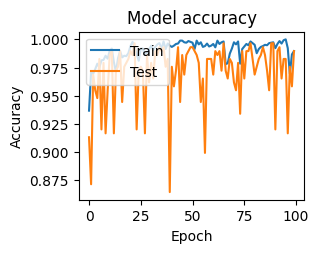

In [12]:
# Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

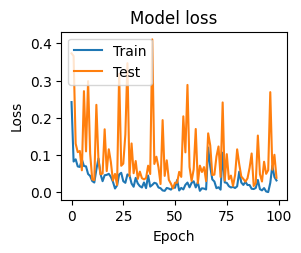

In [13]:
# Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

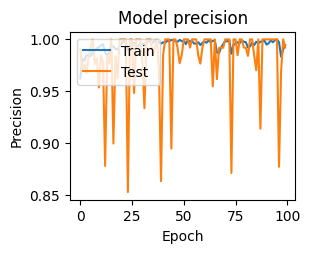

In [14]:
# Precision
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

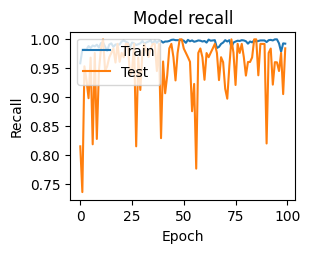

In [15]:
# Recall
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [16]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [17]:
# Function to predict image
def predictImg(imgpath):
    try:
        predict_image = load_img(imgpath, target_size=(64, 64))
        predict_image = img_to_array(predict_image)
        predict_image = np.expand_dims(predict_image, axis=0)
        result = classifier.predict(predict_image)
        return 'Pothole' if result[0][0] >= 0.5 else 'No Pothole'
    except Exception as e:
        print(f"Error occurred: {e}")
        return None


In [18]:
# Predict example images
print(predictImg('/content/drive/MyDrive/testing images/11.jpg'))
print(predictImg('/content/drive/MyDrive/testing images/pic-60-_jpg.rf.4e715308cc8dc7455b767414cda028ab.jpg'))
print(predictImg('/content/drive/MyDrive/testing images/21.jpg'))
print(predictImg('/content/drive/MyDrive/testing images/pic-4-_jpg.rf.f52085b2d1744eeb56ed5a4b8ba0fb0f.jpg'))



Error occurred: [Errno 2] No such file or directory: '/content/drive/MyDrive/testing images/11.jpg'
None
Error occurred: [Errno 2] No such file or directory: '/content/drive/MyDrive/testing images/pic-60-_jpg.rf.4e715308cc8dc7455b767414cda028ab.jpg'
None
Error occurred: [Errno 2] No such file or directory: '/content/drive/MyDrive/testing images/21.jpg'
None
Error occurred: [Errno 2] No such file or directory: '/content/drive/MyDrive/testing images/pic-4-_jpg.rf.f52085b2d1744eeb56ed5a4b8ba0fb0f.jpg'
None


10/10 [==============================] - 7s 635ms/step


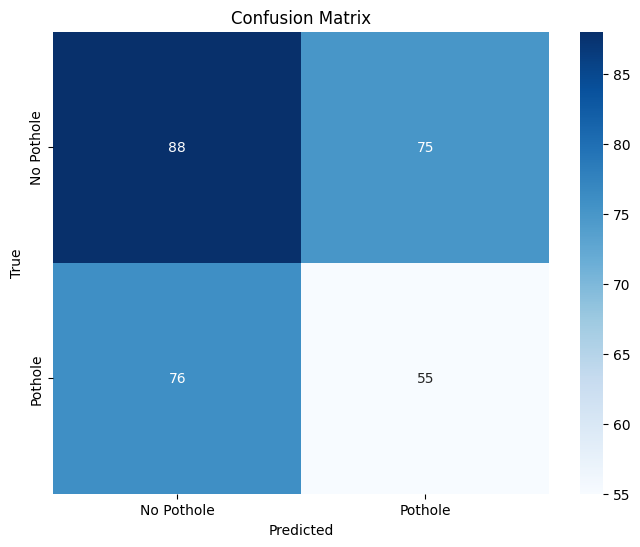

Classification Report
              precision    recall  f1-score   support

  No Pothole       0.54      0.54      0.54       163
     Pothole       0.42      0.42      0.42       131

    accuracy                           0.49       294
   macro avg       0.48      0.48      0.48       294
weighted avg       0.49      0.49      0.49       294



In [19]:
# Generate confusion matrix
def plot_confusion_matrix():
    Y_pred = classifier.predict(test_set)
    y_pred = np.round(Y_pred).astype(int)
    y_true = test_set.classes

    cm = confusion_matrix(y_true, y_pred)
    cm_plot_labels = ['No Pothole', 'Pothole']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_plot_labels, yticklabels=cm_plot_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Print classification report
    print('Classification Report')
    target_names = ['No Pothole', 'Pothole']
    print(classification_report(y_true, y_pred, target_names=target_names))

plot_confusion_matrix()

In [20]:
print(f"Final Training Accuracy: {history.history['accuracy'][-1]}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]}")
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Final Training Accuracy: 0.9895871877670288
Final Validation Accuracy: 0.9895833134651184
Final Training Loss: 0.03159691020846367
Final Validation Loss: 0.03862325847148895
